In [19]:
# %matplotlib widget
# %matplotlib notebook
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
from scipy.signal import correlate, correlation_lags
from scipy.signal import find_peaks, peak_prominences
from lmfit import Model, minimize

from pysmog.data_loading import load_defra_file
from pysmog.data_processing import bin_data
from pysmog.plot_utils import set_matplotlib_defaults
from pysmog.psd import lorentzian, log_lorentzian

In [20]:
set_matplotlib_defaults()

In [21]:
data_tower_hamlets = '../data/2022-01-01-230802122803.csv'
data_tower_soton = '../data/2022-01-01-230802132242.csv'

df  = load_defra_file(data_tower_hamlets)
df2 = load_defra_file(data_tower_soton)
df_numeric = df2.select_dtypes(include='number')
df_numeric = df_numeric.interpolate()

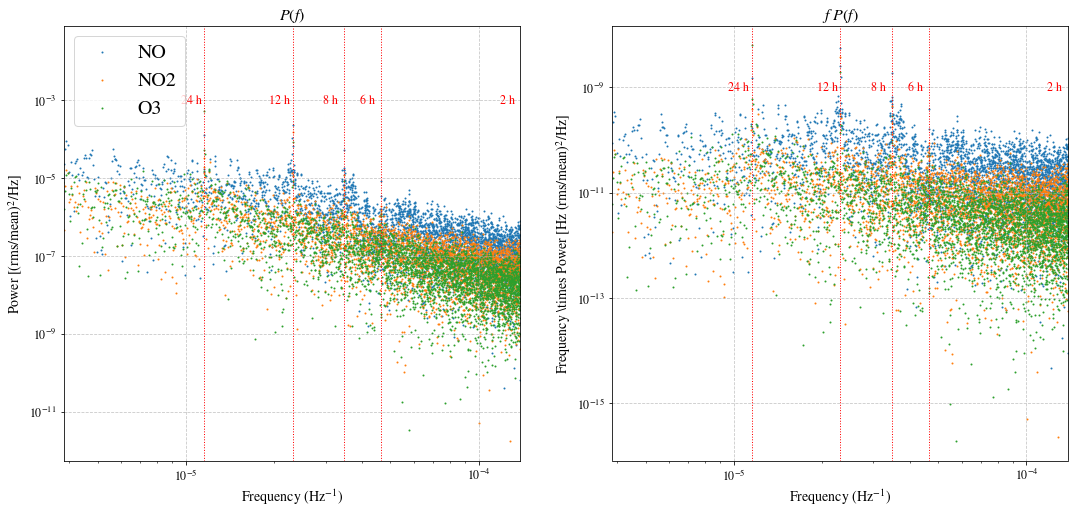

In [22]:
#plt.figure(figsize=(9, 8))
fig, ax = plt.subplots(1,2,figsize=(18, 8))


hours_to_plot = [2, 6, 8, 12, 24]
for t in hours_to_plot:
    freq = 1/(t*3600)
    for a in ax:
        a.axvline(freq, color='red', ls='dotted')
    ax[0].text(0.9*freq, 0.001, f'{t} h', color='red', ha='center', va='center')
    ax[1].text(0.9*freq, 1e-9, f'{t} h', color='red', ha='center', va='center')

for metric in ['NO', 'NO2', 'O3']:
    y = df_numeric[metric]
    N = len(y)
    freqs = np.fft.fftfreq(N, d=3600) #1 Hour Cycle
    
    # Calculate Normalization Constant
    time_bin = np.diff(freqs)[0]
    y_mean = np.mean(y)
    A = (2 * time_bin) / (N * y_mean)
    psd = A*np.abs(np.fft.fft(y))**2

    assert len(freqs) == len(psd)
    N_freqs = len(freqs)
    freqs = freqs[:N_freqs//2] # Cut data at the Nyquist
    psd   = psd[:N_freqs//2]
    
    #plt.loglog(freqs, psd, label=metric)
    ax[0].scatter(freqs, psd, label=metric, s=1)
    ax[1].scatter(freqs, freqs*psd, label=metric, s=1)

    
ax[0].legend(fontsize=20, loc='upper left')
ax[0].set_ylabel(r'Power [(rms/mean)$^{2}$/Hz]')
ax[1].set_ylabel(r'Frequency \times Power [Hz (rms/mean)$^{2}$/Hz]')
ax[0].set_title(r'$P(f)$')
ax[1].set_title(r'$f \ P(f)$')
for a in ax:
    a.loglog()
    a.set_xlabel(r'Frequency (Hz$^{-1}$)')
    a.set_xlim(100*freqs[1], freqs[-1])
plt.show()

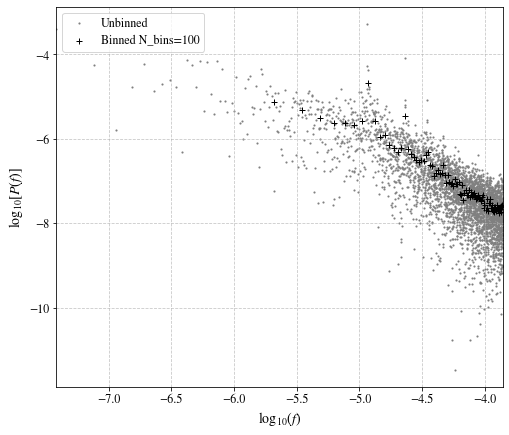

In [23]:
N_bins = 100
freqs_binned, psd_binned = bin_data(freqs, psd, N_bins=N_bins)

# Convert to Log Units while ignoring First value evaluated at f[0]=0
freqs_log, psd_log = np.log10(freqs[1:]), np.log10(psd[1:])
freqs_binned_log, psd_binned_log = np.log10(freqs_binned[1:]), np.log10(psd_binned[1:])

plt.figure(figsize=(8,7))
plt.scatter(freqs_log, psd_log, s=5, marker='.',color='grey', label='Unbinned')
plt.scatter(freqs_binned_log, psd_binned_log, s=30, color='black', marker='+', label=f'Binned N_bins={N_bins}')
plt.legend()

plt.xlim(min(freqs_log), max(freqs_log))
#plt.xticks([min(freqs_log), -0.001, max(freqs_log)])
plt.xlabel(r'$\mathrm{log_{10}}(f)$')
plt.ylabel(r'$\mathrm{log_{10}}[P(f)]$')

plt.show()

In [25]:
def residual(params, xdata, ydata):
    y_model = log_lorentzian(xdata, params)
    return abs(np.log10(model) - np.log10(ydata))

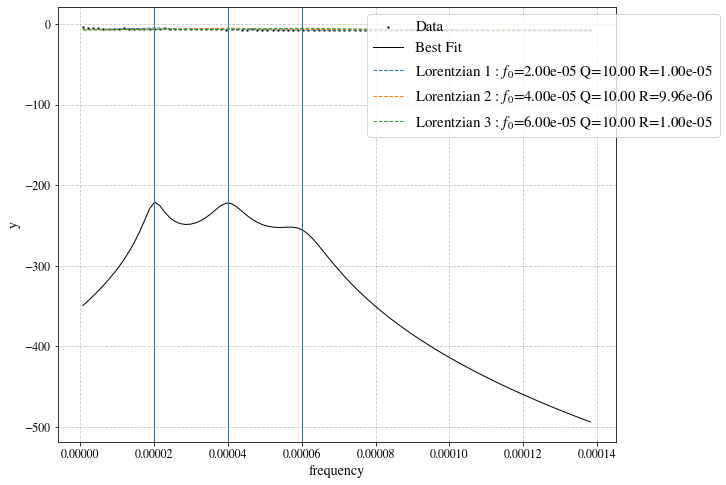

In [42]:
# Lorentzian decomposition of power spectra
xdata = freqs_binned
ydata = np.log10(psd_binned)

# Create Summed Lorentzian Model
N_lorentzians = 3
model_function = log_lorentzian

model = Model(model_function, prefix='lor1_')
for i in range(2, N_lorentzians+1):
    model = model + Model(model_function, prefix=f'lor{i}_')

params = model.make_params()
# Set starting Frequencies
f_0_min, f_0_start, f_0_max = min(xdata), np.mean(xdata), max(xdata)
params[f'lor1_f_0'].set(value=1e-5,  min=7.5e-6, max=2e-5)
params[f'lor2_f_0'].set(value=3e-5, min=2e-5, max=4e-5)
params[f'lor3_f_0'].set(value=5e-5, min=4e-5, max=6e-5)

R_min, R_start, R_max = 1e-8, 5e-7, 1e-5
params[f'lor1_R'].set(value=R_start, min=R_min, max=R_max)
params[f'lor2_R'].set(value=R_start, min=R_min, max=R_max) 
params[f'lor3_R'].set(value=R_start, min=R_min, max=R_max) 

Q_min, Q_start, Q_max = 10, 25, 50
params[f'lor1_Q'].set(value=Q_start, min=Q_min, max=Q_max)
params[f'lor2_Q'].set(value=Q_start, min=Q_min, max=Q_max) 
params[f'lor3_Q'].set(value=Q_start, min=Q_min, max=Q_max) 

data_args = (xdata, ydata)
# result = minimize(fcn=residual, params=params, method='leastsq', args=data_args)

result = model.fit(ydata, params, f=xdata)

# Plotting
plt.figure(figsize=(10,8))

# Plot the data and the fitted curve
plt.scatter(xdata, ydata, label='Data', marker='x', s=3, color='black')
plt.plot(xdata, result.best_fit, color='black', label='Best Fit')


# Plot the components
components = result.eval_components(f=xdata)
for i in range(1, N_lorentzians + 1):
    
    f_0 = result.params[f'lor{i}_f_0'].value
    Q   = result.params[f'lor{i}_Q'].value
    R   = result.params[f'lor{i}_R'].value
    
    plt.plot(xdata, components[f'lor{i}_'], label=f'Lorentzian {i} : $f_0$={f_0:.2e} Q={Q:.2f} R={R:.2e}', ls='--')
    plt.axvline(f_0)
    
plt.xlabel('frequency')
plt.ylabel('y')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=15)
plt.show()

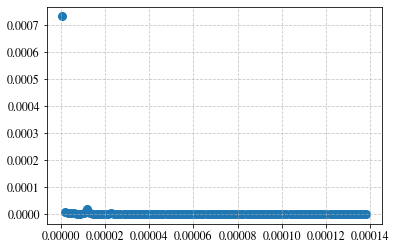

In [34]:
# Lorentzian decomposition of power spectra

xdata = freqs_binned
ydata = psd_binned
xdata_log = np.log10(xdata)
ydata_log = np.log10(ydata)
plt.scatter(xdata, ydata)

In [44]:
def summed_lorenzian(xdata, ):
    return lorentzian() + lorentzian()

SyntaxError: incomplete input (970954329.py, line 1)

[]

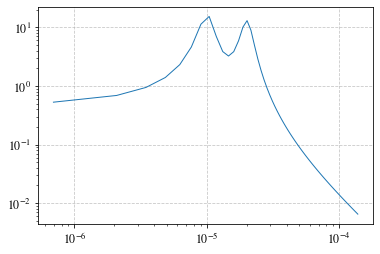

In [43]:
y_model = lorentzian(xdata, R=0.01, Q=10, f_0=2e-5) + lorentzian(xdata, R=0.01, Q=10, f_0=1e-5)
plt.plot(xdata,y_model)
plt.loglog()

In [ ]:
plt.scatter(xdata, ydata, label='Data', marker='x', s=3, color='black')
plt.plot(xdata, log_lorentzian(xdata, R=0.000006, Q=50.0, f_0=1.2e-5))

In [ ]:
plt.figure(figsize=(7,5))

# Plot the data and the fitted curve
plt.scatter(xdata, ydata, label='Data', marker='x', s=3, color='black')
plt.plot(xdata, result.best_fit, color='black', label='Best Fit')


# Plot the components
components = result.eval_components(f=xdata)
for i in range(1, N_lorentzians + 1):
    
    f_0 = result.params[f'lor{i}_f_0'].value
    Q   = result.params[f'lor{i}_Q'].value
    R   = result.params[f'lor{i}_R'].value
    
    plt.plot(xdata, components[f'lor{i}_'], label=f'Lorentzian {i} : $f_0$={f_0:.2e} Q={Q:.2f} R={R:.2e}', ls='--')
    plt.axvline(f_0)
    
plt.xlabel('frequency')
plt.ylabel('y')
plt.loglog()
plt.legend(loc='upper right', bbox_to_anchor=(1.92, 1.0), fontsize=15)
plt.show()